In [3]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from pprint import pprint

In [4]:
%load_ext autoreload
%autoreload 1
%aimport main
%aimport data_utils
%aimport contrastive_data
%aimport models
%aimport scoring

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from contrastive_data import *
from data_utils import *
from main import *
from models import *
from scoring import *

# Data and model

In [6]:
data_path = '/home/lguirardel/data/perturb_comp/data/KRAS/'


In [7]:
paths = get_paths(data_path)
counts = load_data(*paths, group_wt_like=True)

	Reading files...
		Reading matrix


		Reading genes and cells
		Reading variant data
	Merging and processing...
		Grouping WT-like variants.
		58 variant classes


Run from here to re-split without reloading all data (will be necessary if wtlike is changed however)

In [8]:
run_name = 'KRAS_02'
dir_name = join('models',run_name)
! cat models/{run_name}/config.ini

restart = true
config-file = models/KRAS_02/config.ini
loss = standard
alpha = 0.0
dropout = 0.1
embed-dim = 40
margin = 1
weight-decay = 0.01
batch-size = 128
positive-fraction = 0.5
lr = 0.001
n-epochs = 10000
shape = [100, 100]
n-workers = 4


In [9]:
df_train, df_seen, df_unseen = load_split(join(dir_name, 'split'), counts, )
df_dict = {
    'train':df_train,
    'seen':df_seen,
    'unseen':df_unseen,
}

In [10]:
dl_train, dl_seen, dl_unseen = make_loaders(
    df_train, df_seen,df_unseen, batch_size=64, dataset_class=SiameseDataset,n_workers=1,pos_frac=0.5)

In [11]:
# model = torch.load(join(dir_name,'model.pkl'), map_location='cpu')
model = torch.load(join(dir_name,'best_model.pkl'), map_location='cpu')

In [12]:
model

Siamese(
  (network): MLP(
    (layers): Sequential(
      (0): Linear(in_features=1145, out_features=100, bias=True)
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): ELU(alpha=1.0)
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=100, out_features=40, bias=True)
    )
  )
)

# PCA

In [13]:
X = torch.tensor(df_train.drop(columns=['variant','Variant functional class']).to_numpy(), dtype=torch.float32)
embeds = []
for i,x in enumerate(X):
    with torch.no_grad():
        embeds.append(model.network.forward(x))
embeds = torch.stack(embeds)
pca = PCA(2).fit(embeds)


# Embedding distribution

In [12]:
make_dir_if_needed(f'plots/embeds/{run_name}')

In [30]:
hue_order = ['WT-like', 'Impactful I', 'Impactful II', 'Impactful III', 'Impactful IV']

In [87]:
subset = 'train'
df = {'train':df_train, 'test_seen':df_seen, 'test_unseen':df_unseen}[subset]

X = torch.tensor(df.drop(columns=['variant','Variant functional class']).to_numpy(), dtype=torch.float32)
embeds = []
for i,x in enumerate(X):
    with torch.no_grad():
        embeds.append(model.network.forward(x))

embeds = torch.stack(embeds)
emb_red = pca.transform(embeds)


/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

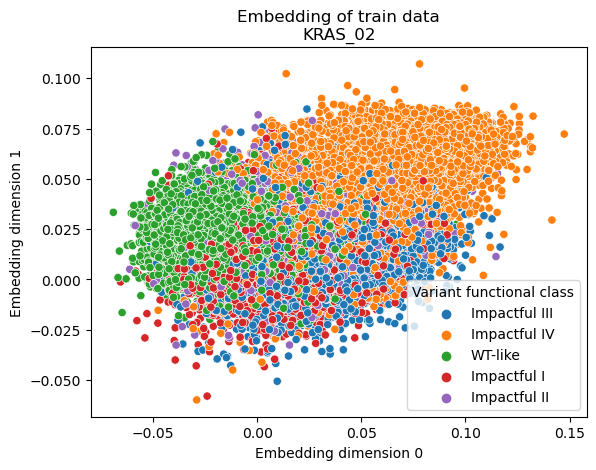

In [35]:
i,j = 0,1
sns.scatterplot(x=embeds[:,i], y=embeds[:,j], hue = df['Variant functional class'])
plt.xlabel(f'Embedding dimension {i}')
plt.ylabel(f'Embedding dimension {j}')
plt.title(f'Embedding of {subset} data\n{run_name}')
plt.savefig(f'plots/embeds/{run_name}/{subset}_embed_{i}_{j}_scatter.pdf')

In [36]:
# sns.kdeplot(x=embeds[:,i], y=embeds[:,j], hue = df['Variant functional class'], levels=5, common_norm=False)
# plt.xlabel(f'Embedding dimension {i}')
# plt.ylabel(f'Embedding dimension {j}')
# plt.title(f'{subset} data embedding distribution\n{run_name}')
# plt.savefig(f'plots/embeds/{run_name}/{subset}_embed_{i}_{j}_kde.pdf')

In [37]:
print(f'Explained variance : {(pca.explained_variance_ratio_).sum()*100:.1f} %')


Explained variance : 98.7 %


/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

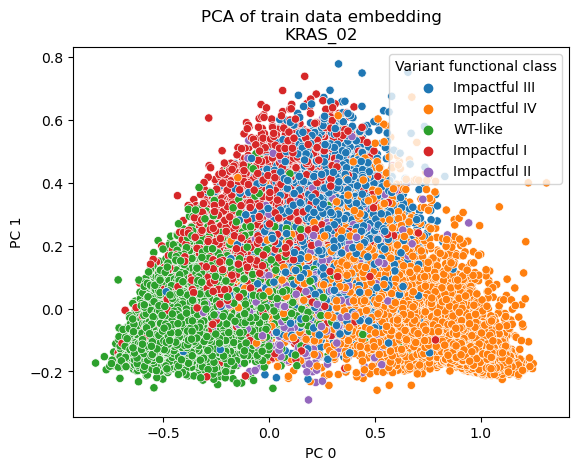

In [38]:
sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['Variant functional class'])
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data embedding\n{run_name}')
plt.savefig(f'plots/embeds/{run_name}/{subset}_embed_pca_scatter.pdf')

/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

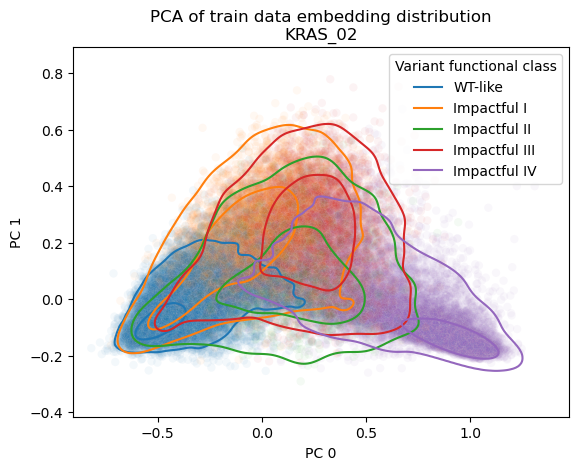

In [39]:
sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['Variant functional class'], hue_order=hue_order, alpha=0.05, legend=False)
sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['Variant functional class'], hue_order=hue_order, levels=3, common_norm=False)
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data embedding distribution\n{run_name}' )
plt.savefig(f'plots/embeds/{run_name}/{subset}_embed_pca_kde.pdf')

In [40]:
df[df['Variant functional class'] == 'Impactful I'].variant.unique()

array(['C185Y', 'T74A', 'L52F', 'D57N', 'Q99E', 'R41K', 'Q22H', 'E31K'],
      dtype=object)

In [41]:
# variants = ['R110L', 'G245D', 'R213Q','R158H']


# sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['Variant functional class'], levels=5, common_norm=False, legend=False,palette='gray')
# plt.xlabel(f'PC 0')
# plt.ylabel(f'PC 1')
# plt.title(f'PCA of {subset} data embedding distribution\n{run_name}' )
# for v in variants:
#     idx = (df['variant'] == v).to_numpy()
#     plt.scatter(x=emb_red[idx,0], y=emb_red[idx,1],label=v, marker='x',alpha=0.5)
# plt.legend()

# Comparison with simple PCA

In [89]:
df_train.columns

Index(['A1BG', 'AATF', 'ABCA1', 'ABCC2', 'ABCD4', 'ABCG2', 'ABL2',
       'AC006262.4', 'AC006262.5', 'AC090498.1',
       ...
       'ZFP36L1', 'ZFPM1', 'ZMAT3', 'ZNF185', 'ZNF296', 'ZNF467', 'ZNF57',
       'ZNF622', 'variant', 'Variant functional class'],
      dtype='object', length=1147)

In [93]:
pca_base = PCA(2).fit(df_train.iloc[:,:-2])

X_red = pca_base.transform(df.iloc[:,:-2])


/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprec

In [92]:
print(f'Explained variance : {(pca_base.explained_variance_ratio_).sum()*100:.1f} %')


Explained variance : 5.2 %


/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

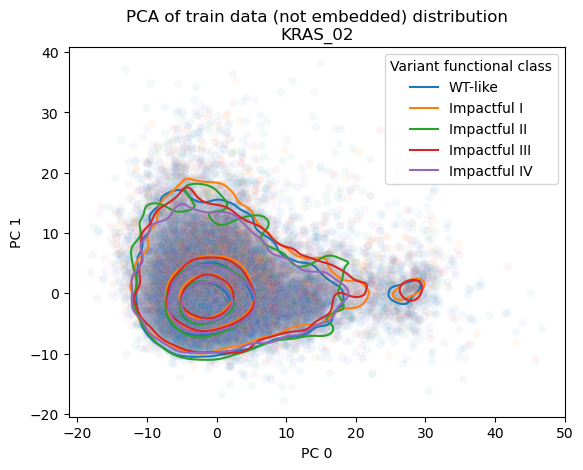

In [96]:
sns.scatterplot(x=X_red[:,0], y=X_red[:,1], hue = df['Variant functional class'], hue_order=hue_order, alpha=0.05, legend=False)
sns.kdeplot(x=X_red[:,0], y=X_red[:,1], hue = df['Variant functional class'], hue_order=hue_order, levels=4, common_norm=False)
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data (not embedded) distribution\n{run_name}' )
plt.savefig(f'plots/embeds/{run_name}/{subset}_pca_kde.pdf')

In [100]:
df.iloc[:,:-2].std(axis=0).sort_values()

RP11-338I21.1    0.710734
NTS              0.753617
ATF3             0.854006
LINC01220        0.855670
IGF2             0.890681
                   ...   
AC006262.5       1.014738
SAMD11           1.015180
PHGDH            1.017428
ASNS             1.024596
NUPR1            1.026945
Length: 1145, dtype: float64

# ROC Scores

## Intra-group

In [42]:
subset = 'train'
group = 'Impactful II'
df = df_train

df = df[df['Variant functional class'] == group]

X = torch.tensor(df.drop(columns=['variant','Variant functional class']).to_numpy(), dtype=torch.float32)
embeds = []
for i,x in enumerate(X):
    with torch.no_grad():
        embeds.append(model.network.forward(x))
embeds = torch.stack(embeds)

emb_red = pca.transform(embeds)


In [43]:
# sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['variant'], levels=3, common_norm=False)
# plt.xlabel(f'PC 0')
# plt.ylabel(f'PC 1')
# plt.title(f'PCA of {subset} data embedding distribution ({group})\n{run_name}' )
# plt.savefig(f'plots/embeds/{run_name}/{subset}_{group}_embed_pca_kde.pdf')

In [44]:
dl = DataLoader(SiameseDataset(df, p=0.5), batch_size=64, shuffle=True)
metrics = test_loop(dl, model, SiameseLoss(margin=1, alpha=0), margin=1, device='cpu')
print(f'Metrics for {subset} data, {group=}')
pprint(metrics)

Metrics for train data, group='Impactful II'
{'_n_neg': 837,
 '_n_pos': 777,
 'dist_neg': 0.3968481123447418,
 'dist_pos': 0.372906357049942,
 'l2_penalty': 0.0,
 'loss': 0.29179945014990294,
 'roc': 0.5366303324699402}


## Inter-group

En chantier - je pense que ça fait plus de sens avec une metrique 1-nn que avec la ROC 

In [45]:
subset = 'train'
group1 = 'Impactful I'
group2 = 'Impactful II'
df = df_train

df1 = df[df['Variant functional class'] == group1]
df2 = df[df['Variant functional class'] == group2]


In [46]:
dl = DataLoader(
    BipartiteDataset(df1, df2, p1=0.5), # will always get 
    batch_size=64, shuffle=True,
)

In [47]:
metrics = test_loop(dl, model, SiameseLoss(margin=1, alpha=0), device='cpu', margin=1)
print(f'Metrics for {subset} data, {group1=}, {group2=}')
pprint(metrics)

Metrics for train data, group1='Impactful I', group2='Impactful II'
{'_n_neg': 2754,
 '_n_pos': 2825,
 'dist_neg': 0.44673478603363037,
 'dist_pos': 0.37004172801971436,
 'l2_penalty': 0.0,
 'loss': 0.25942185605791485,
 'roc': 0.610097348690033}


# kNN scores

This score needs a reference (training) and a test set (seen)

In [25]:
k=1
s = knn_class_score(model.network,dl_train.dataset.x, dl_seen.dataset.x, dl_train.dataset.y,  dl_seen.dataset.y, k=k)
n_cell = len(dl_train.dataset.y)
n_max = dl_train.dataset.y.value_counts().max()


/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

In [27]:
print(f'Score {s*100:.2f} % ({k}-nn). Best constant predictor : {100*n_max/n_cell:.2f} %')

Score 43.14 % (1-nn). Best constant predictor : 52.03 %


Well, the WT-like huge imbalance is messing results up.

In [28]:
y = dl_train.dataset.y
y.count()

57354

In [29]:
y.value_counts()

variant
WT-like    29843
G60D         771
A59G         770
A146P        765
Q61P         761
Q22H         758
R68S         757
AG59GV       754
C185Y        754
G60V         749
A146V        748
D119G        745
Q99E         742
A59T         731
I36M         728
R41K         717
A146T        717
D57N         700
Q61R         694
T58I         683
G12A         683
E31K         660
T74A         659
Q22K         659
P34R         634
K117R        632
K117N        629
Q61L         602
G12C         595
L52F         589
L19F         566
G13C         565
P34L         555
G13E         554
G12Y         545
AG11TD       541
G12R         535
N26Y         534
Q61A         527
D33E         514
G13V         500
Q61K         443
G12S         385
G12D         361
Name: count, dtype: int64

# Training

In [48]:
from tensorboard.backend.event_processing import event_accumulator

In [49]:
ea = event_accumulator.EventAccumulator(f'runs/{run_name}')

## Checking score

In [50]:
metrics = test_loop(dl_seen, model, SiameseLoss(margin=1, alpha=0),  margin=1, device='cpu')
pprint(metrics)

{'_n_neg': 9615,
 '_n_pos': 9503,
 'dist_neg': 0.7669540643692017,
 'dist_pos': 0.3554089367389679,
 'l2_penalty': 0.0,
 'loss': 0.20733963010402826,
 'roc': 0.7765908241271973}


## Plotting training curves

In [51]:
make_dir_if_needed('plots/runs')

In [80]:
hue_order_sets = ['train','test_seen',
    # 'test_unseen'
    ]

In [52]:
ea.Reload()

In [53]:
ea.scalars.Keys()

['train/dist_pos',
 'train/dist_neg',
 'train/l2_penalty',
 'train/loss',
 'train/roc',
 'train/lr',
 'test_seen/dist_pos',
 'test_seen/dist_neg',
 'test_seen/l2_penalty',
 'test_seen/loss',
 'test_seen/roc',
 'test_unseen/dist_pos',
 'test_unseen/dist_neg',
 'test_unseen/l2_penalty',
 'test_unseen/loss',
 'test_unseen/roc']

In [54]:
# def get_df_from_tb(ea:event_accumulator.EventAccumulator, keys:List[str]=None) :
#     df = pd.DataFrame()
#     if keys is None:
#         keys = ea.scalars.Keys()
#     for key in keys:
#         events = ea.scalars.Items(key)
#         df[key] = pd.Series(data=[e.value for e in events], index=[e.step for e in events])
#     return df

In [55]:
def get_df_from_tb(ea:event_accumulator.EventAccumulator, keys:List[str]=None) :
    df = []
    if keys is None:
        keys = ea.scalars.Keys()
    for key in keys:
        events = ea.scalars.Items(key)
        for e in events:
            data_set, variable = key.split('/')

            df.append({'data set':data_set, 'variable':variable, 'epoch':e.step,'value':e.value})
    return pd.DataFrame.from_records(df)

In [56]:
df = get_df_from_tb(ea,)

In [57]:
df

,data set,variable,epoch,value
0,train,dist_pos,0,0.495484
1,train,dist_pos,1,0.411038
2,train,dist_pos,2,0.393730
3,train,dist_pos,3,0.381325
4,train,dist_pos,4,0.376074
...,...,...,...,...
23809,test_unseen,roc,1482,0.695429
23810,test_unseen,roc,1483,0.694807
23811,test_unseen,roc,1484,0.686477
23812,test_unseen,roc,1485,0.703162


In [58]:
df = df[(df['data set']!='test_unseen')]

/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

(-10.0, 200.0)

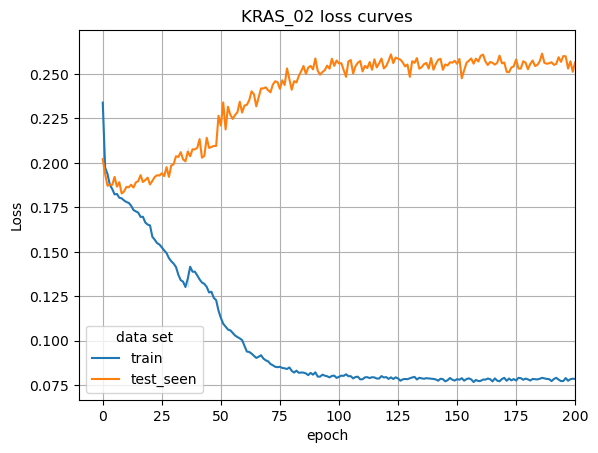

In [63]:
sns.lineplot(df[(df.variable == 'loss')], x='epoch',y='value',hue='data set')
plt.title(f'{run_name} loss curves')
plt.ylabel('Loss')
# plt.yscale('logit')
plt.savefig(f'plots/runs/{run_name}_loss.pdf')
plt.grid()
plt.xlim([-10,200])


/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

(-10.0, 200.0)

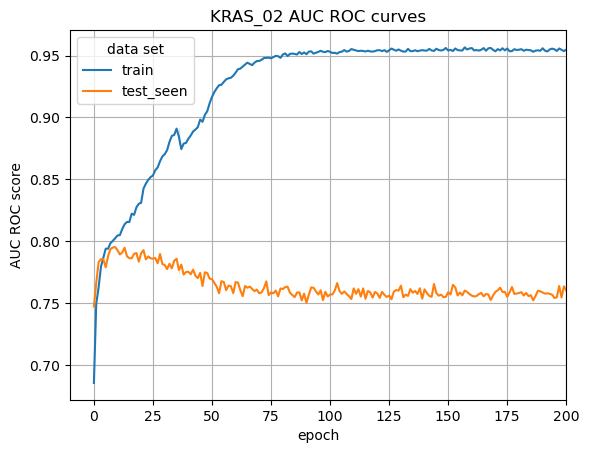

In [64]:
sns.lineplot(df[df.variable == 'roc'], x='epoch',y='value',hue='data set')
plt.title(f'{run_name} AUC ROC curves')
plt.ylabel('AUC ROC score')
# plt.yscale('logit')
plt.savefig(f'plots/runs/{run_name}_roc.pdf')
plt.grid()
plt.xlim([-10,200])


/tmp/ipykernel_6820/3901504397.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(df_smooth[df.variable.str.startswith('dist')], x='epoch',y='value',hue='data set', hue_order=hue_order_sets, style='variable')
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version

(-10.0, 200.0)

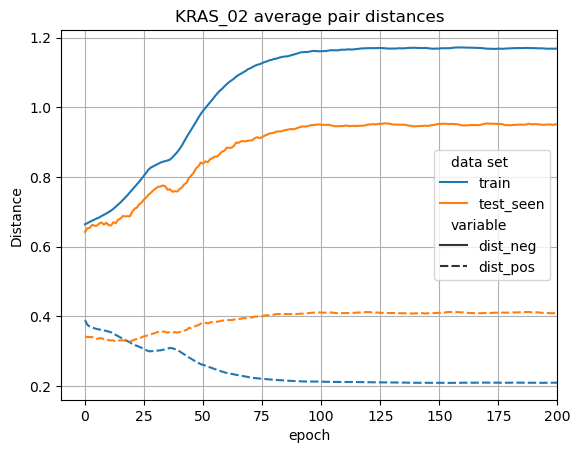

In [83]:
l  = 10 
df_smooth = df.groupby(['data set','variable']).value.rolling(window=l).mean().shift(-l+1).reset_index([0,1])
df_smooth['epoch'] = df.epoch
# df_smooth = df
sns.lineplot(df_smooth[df.variable.str.startswith('dist')], x='epoch',y='value',hue='data set', hue_order=hue_order_sets, style='variable')
plt.title(f'{run_name} average pair distances')
plt.ylabel('Distance')
# plt.yscale('logit')
plt.savefig(f'plots/runs/{run_name}_dist.pdf')
plt.grid()
plt.xlim([-10, 200])


In [71]:
df_smooth

,data set,variable,value
10422,test_seen,dist_neg,NaN
10423,test_seen,dist_neg,NaN
10424,test_seen,dist_neg,NaN
10425,test_seen,dist_neg,NaN
10426,test_seen,dist_neg,NaN
...,...,...,...
7440,train,roc,0.954085
7441,train,roc,0.954092
7442,train,roc,0.954126
7443,train,roc,0.954094
